In [ ]:
import sys
print(sys.prefix)

In [ ]:
from DatabaseMergerCode.DatabaseMerger import OptunaStudyMerger

merger = OptunaStudyMerger(
    db_paths=[
        "Databases/optuna_study.db",
        "Databases/optuna_study_1.db",
        "Databases/optuna_study_2.db",
        "Databases/optuna_study_3.db",
        "Databases/optuna_study_4.db",
    ],
    merged_db_path="sqlite:///merged_optuna.db",
    merged_study_name="sindy_opt_merged",
    top_k=5
)

merger.merge_top_trials()
merger.print_top_trials()

In [1]:

from TrainingCode.ValidateTraining import TopTrialSelector, TrialEvaluator

# --- CONFIGURATION ---
DB_PATH = "merged_optuna.db"
STUDY_NAME = "sindy_opt_merged"
TOP_K = 5
TRIAL_INDEX_TO_RUN = 1  # <-- Change this (1 = best, 2 = second-best, etc.)


In [2]:
# --- STEP 1: Load and Save Top Trials ---
selector = TopTrialSelector(db_path=DB_PATH, study_name=STUDY_NAME, top_k=TOP_K)
selector.save_top_params("top_trial_params.pkl")

# --- STEP 2: Load Selected Trial Params ---
trial_params = selector.get_trial_params(TRIAL_INDEX_TO_RUN)

print(f"\n🧪 Parameters from trial index {TRIAL_INDEX_TO_RUN}:")
for key, value in trial_params.items():
    print(f"  {key}: {value}")


📂 Loading study: sindy_opt_merged from merged_optuna.db
✅ Loaded 5 top trials.
💾 Saved top-5 trial parameters to top_trial_params.pkl
🔍 Merged Parameters:
 dict_keys(['model', 'case', 'input_dim', 'latent_dim', 'poly_order', 'include_sine', 'fix_coefs', 'svd_dim', 'delay_embedded', 'scale', 'coefficient_initialization', 'coefficient_initialization_constant', 'widths_ratios', 'max_epochs', 'patience', 'batch_size', 'learning_rate', 'lr_decay', 'loss_weight_rec', 'loss_weight_sindy_z', 'loss_weight_sindy_x', 'loss_weight_sindy_regularization', 'loss_weight_integral', 'loss_weight_x0', 'loss_weight_layer_l2', 'loss_weight_layer_l1', 'coefficient_threshold', 'threshold_frequency', 'print_frequency', 'sindy_pert', 'ode_net', 'ode_net_widths', 'exact_features', 'use_bias', 'tend', 'dt', 'rfe_frequency', 'train_ratio', 'data_path', 'save_checkpoints', 'save_freq', 'learning_rate_sched', 'use_sindycall', 'sindycall_start', 'rfe_start', 'sindy_print_rate', 'loss_print_rate', 'sparse_weighting',

In [3]:
# --- STEP 3: Run Training + Plot Evaluation ---
merged_params = selector.get_trial_params(TRIAL_INDEX_TO_RUN)
evaluator = TrialEvaluator(merged_params)
#import pprint
#pprint.pprint(merged_params)
print("Learning Rate:", merged_params["learning_rate"])
print("LR Decay:", merged_params["lr_decay"])
#merged_params["lr_decay"] = 0.999010438775539 
#print("Adjusted Learning Decay:", merged_params["lr_decay"])

🔍 Merged Parameters:
 dict_keys(['model', 'case', 'input_dim', 'latent_dim', 'poly_order', 'include_sine', 'fix_coefs', 'svd_dim', 'delay_embedded', 'scale', 'coefficient_initialization', 'coefficient_initialization_constant', 'widths_ratios', 'max_epochs', 'patience', 'batch_size', 'learning_rate', 'lr_decay', 'loss_weight_rec', 'loss_weight_sindy_z', 'loss_weight_sindy_x', 'loss_weight_sindy_regularization', 'loss_weight_integral', 'loss_weight_x0', 'loss_weight_layer_l2', 'loss_weight_layer_l1', 'coefficient_threshold', 'threshold_frequency', 'print_frequency', 'sindy_pert', 'ode_net', 'ode_net_widths', 'exact_features', 'use_bias', 'tend', 'dt', 'rfe_frequency', 'train_ratio', 'data_path', 'save_checkpoints', 'save_freq', 'learning_rate_sched', 'use_sindycall', 'sindycall_start', 'rfe_start', 'sindy_print_rate', 'loss_print_rate', 'sparse_weighting', 'system_coefficients', 'update_freq', 'sindy_fixed_mask', 'sindy_fixed_values'])
Generating Lorenz system...
Learning Rate: 0.0099623

🔍 Merged Parameters:
 dict_keys(['model', 'case', 'input_dim', 'latent_dim', 'poly_order', 'include_sine', 'fix_coefs', 'svd_dim', 'delay_embedded', 'scale', 'coefficient_initialization', 'coefficient_initialization_constant', 'widths_ratios', 'max_epochs', 'patience', 'batch_size', 'learning_rate', 'lr_decay', 'loss_weight_rec', 'loss_weight_sindy_z', 'loss_weight_sindy_x', 'loss_weight_sindy_regularization', 'loss_weight_integral', 'loss_weight_x0', 'loss_weight_layer_l2', 'loss_weight_layer_l1', 'coefficient_threshold', 'threshold_frequency', 'print_frequency', 'sindy_pert', 'ode_net', 'ode_net_widths', 'exact_features', 'use_bias', 'tend', 'dt', 'rfe_frequency', 'train_ratio', 'data_path', 'save_checkpoints', 'save_freq', 'learning_rate_sched', 'use_sindycall', 'sindycall_start', 'rfe_start', 'sindy_print_rate', 'loss_print_rate', 'sparse_weighting', 'system_coefficients', 'update_freq', 'sindy_fixed_mask', 'sindy_fixed_values'])
Generating Lorenz system...
[DEBUG] Final coefficien

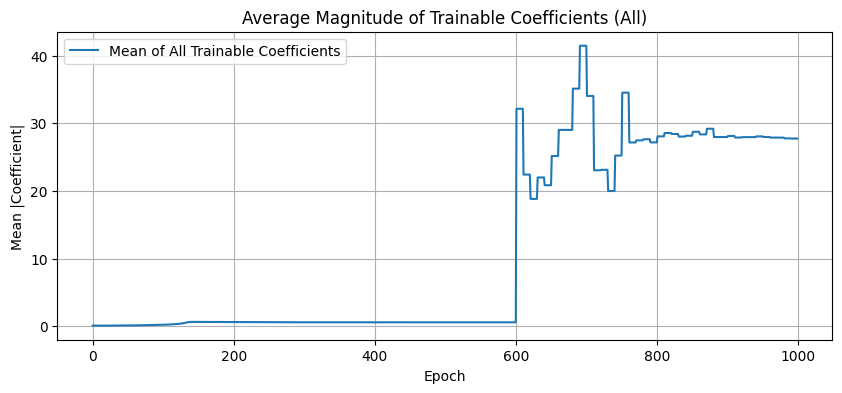

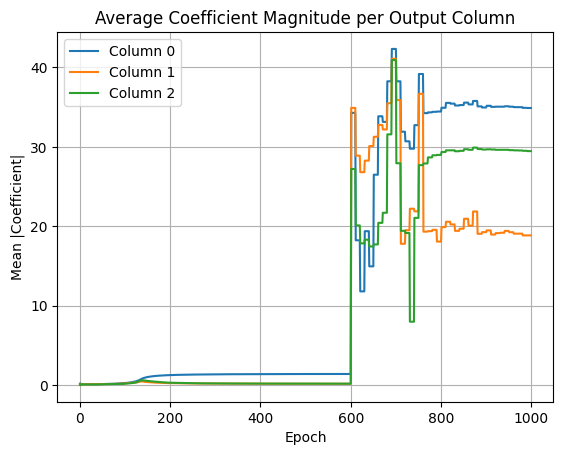


Final SINDy Model:
dz0/dt = 50.0000 * 1 + 50.0000 * z0 + 50.0000 * z1 + 50.0000 * z2 + 5.2091 * z0z0 + 5.1604 * z0z1 + -32.7200 * z0z2 + -5.8186 * z1z1 + -50.0000 * z1z2 + -50.0000 * z2z2
dz1/dt = 50.0000 * 1 + 0.4802 * z0 + 50.0000 * z1 + 50.0000 * z2 + -1.0142 * z0z0 + 3.5421 * z0z1 + 9.3270 * z0z2 + 7.1065 * z1z1 + 4.1374 * z1z2 + -12.8744 * z2z2
dz2/dt = 50.0000 * 1 + 50.0000 * z0 + 50.0000 * z1 + 50.0000 * z2 + 0.5876 * z0z0 + 7.9311 * z0z1 + -2.5348 * z0z2 + 9.9599 * z1z1 + -34.3667 * z1z2 + -39.2332 * z2z2


In [ ]:
import numpy as np
import math
np.math = math
# --- STEP 3: Run Training + Plot Evaluation ---
merged_params = selector.get_trial_params(TRIAL_INDEX_TO_RUN)

# Manually increase L1 regularization by a factor of 10
if "loss_weight_layer_l1" in merged_params:
    merged_params["loss_weight_layer_l1"] *= 10
else:
    merged_params["loss_weight_layer_l1"] = 1e-3  

if "loss_weight_sindy_z" in merged_params:
    merged_params["loss_weight_sindy_z"] *= 1
else:
    merged_params["loss_weight_sindy_z"] = 1e-3  

if "loss_weight_sindy_x" in merged_params:
    merged_params["loss_weight_sindy_x"] *= 1
else:
    merged_params["loss_weight_sindy_x"] = 1e-3  

merged_params["coefficient_threshold"] = 0.001  # or whatever value 
merged_params["max_epochs"] = 3000
merged_params["rfe_threshold"] = merged_params["coefficient_threshold"]

evaluator = TrialEvaluator(merged_params)
evaluator.train_model()

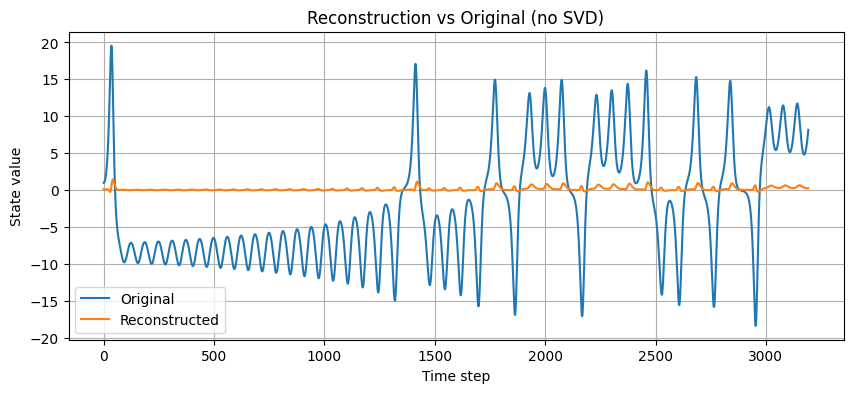

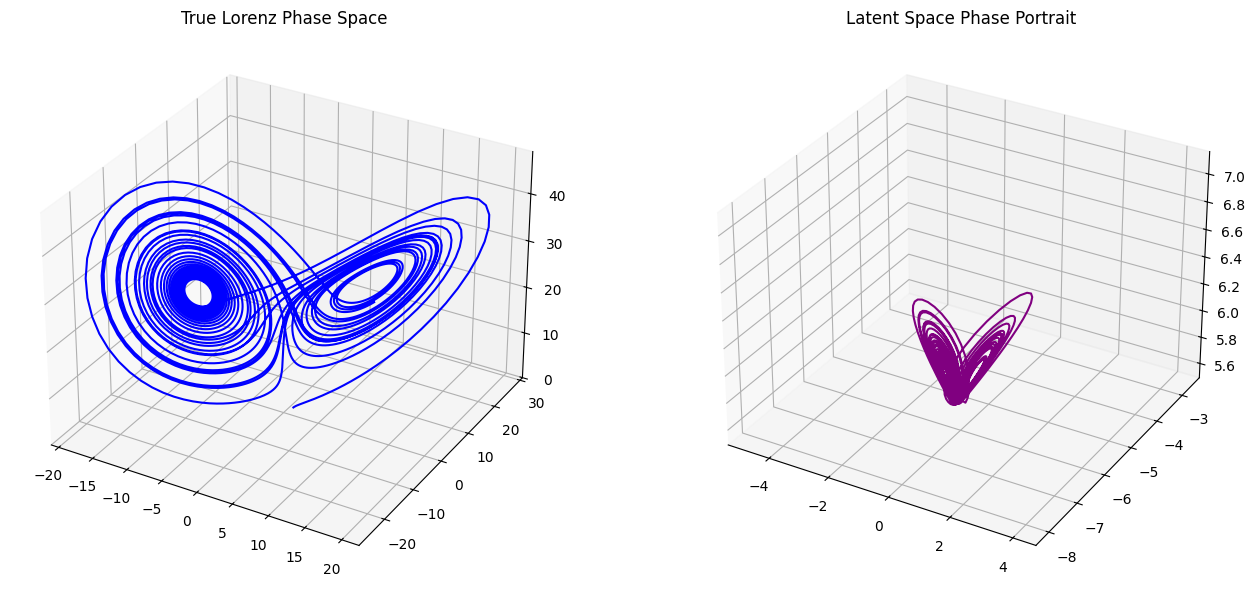

Simulating SINDy model from latent z0...


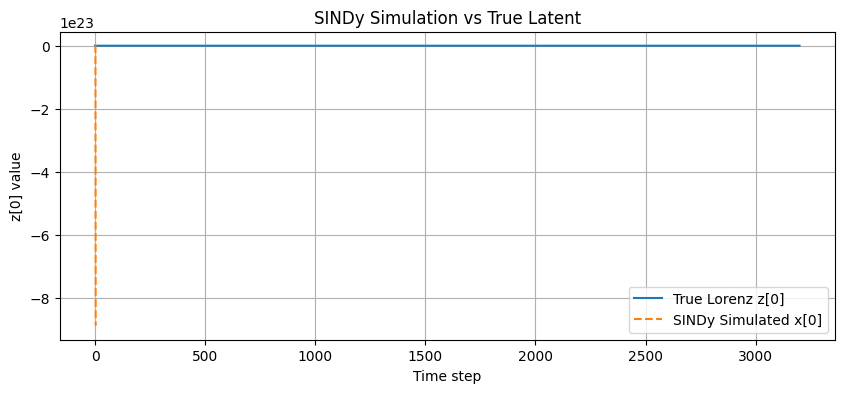

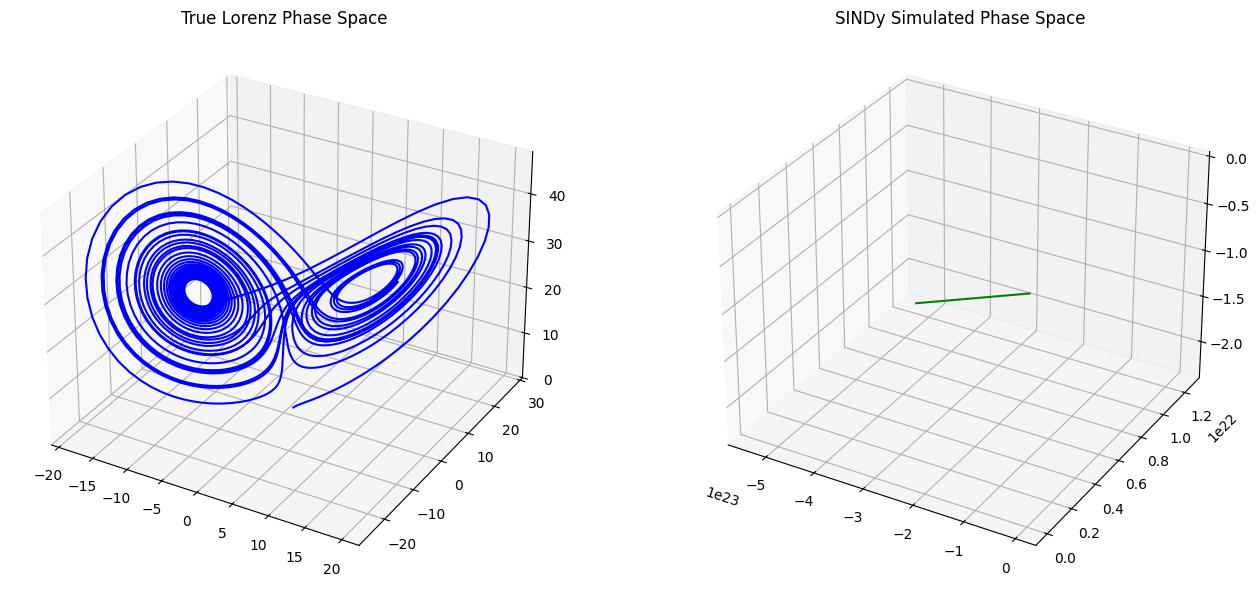

In [5]:
evaluator.evaluate_and_plot()

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def plot_loss_curves(history, norm=False):
    """
    Plots training/validation loss curves for all loss components in history.
    
    Args:
        history (dict): Dictionary with keys like 'train_total', 'val_rec', etc.
        norm (bool): If True, normalize each curve by its initial value.
    """
    assert isinstance(history, dict), "Expected a dict-style history (not a list)."

    # Collect unique loss names (excluding 'train_' and 'val_')
    keys = list(history.keys())
    loss_names = sorted(set(k.split('_', 1)[1] for k in keys))

    n_plots = len(loss_names)
    n_cols = 2
    n_rows = (n_plots + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
    axes = axes.flatten()

    for i, loss in enumerate(loss_names):
        ax = axes[i]
        for prefix in ['train', 'val']:
            key = f"{prefix}_{loss}"
            if key in history:
                values = history[key]
                if norm:
                    values = [v / values[0] for v in values]
                ax.plot(values, label=prefix)

        ax.set_title(f"{loss} loss")
        ax.set_yscale("log")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend()

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

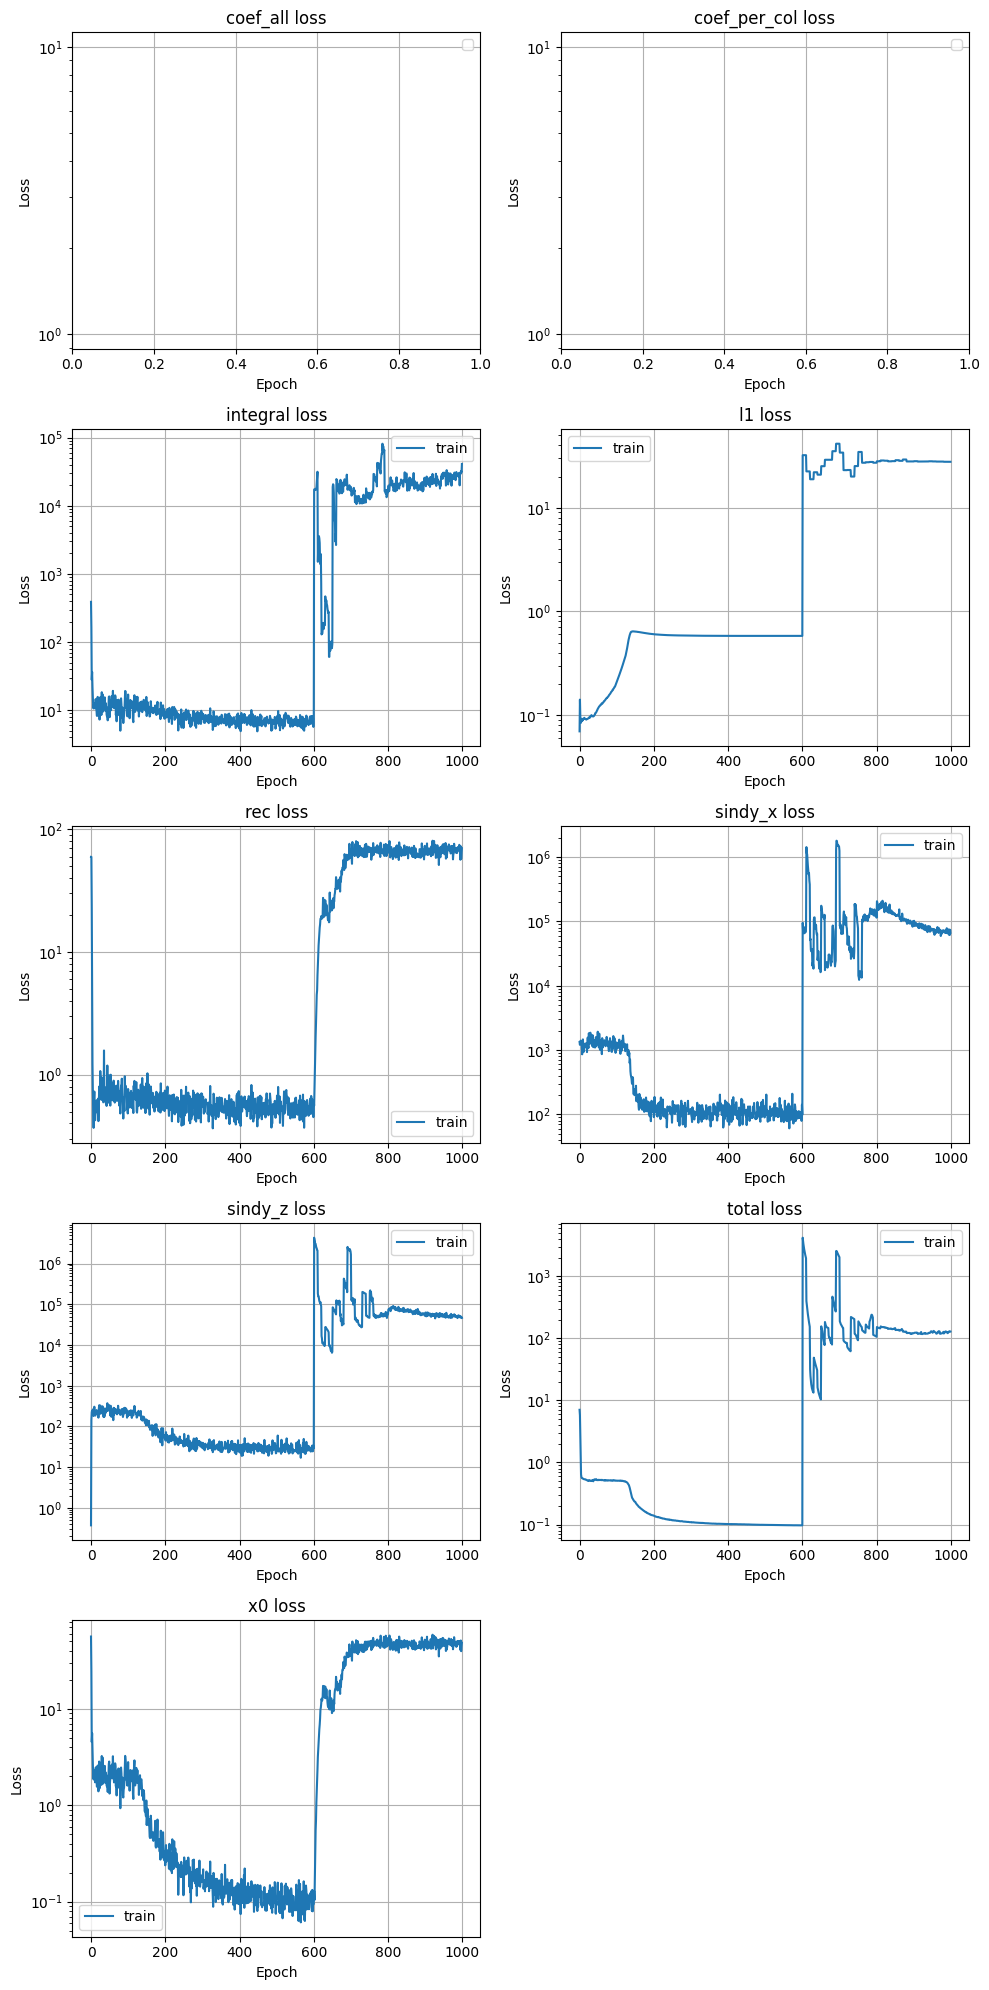

In [7]:
plot_loss_curves(evaluator.trainer.history, norm=False)